# 1: Environment Check

In [ ]:
# Check Python version
import sys
print("🐍 Python version:", sys.version)

🐍 Python version: 3.13.9 (tags/v3.13.9:8183fa5, Oct 14 2025, 14:09:13) [MSC v.1944 64 bit (AMD64)]


# 2: Verify Ollama Is Working

In [1]:
from langchain_ollama import ChatOllama

llm = ChatOllama(model="llama3", temperature=0)

response = llm.invoke("Say hello in one short sentence.")
print("🤖 Ollama response:")
print(response.content)

🤖 Ollama response:
Hello!


# 3: Test Web Scraper Alone

In [4]:
from scraper import scrape_website

test_url = "https://www.langchain.com/"

content = scrape_website(test_url)

print("📄 Scraped content length:", len(content))
print("\n🔍 Preview:")
print(content)

📄 Scraped content length: 4673

🔍 Preview:
LangChain LangSmith products power top engineering teams, from AI startups to global enterprises Visibility &Â control See exactly what's happening at every step of your agent. Steer your agent to accomplish critical tasks the way you intended. Fast iteration Rapidly move through build, test, deploy, learn, repeat with workflows across the entire agent engineering lifecycle. Durable performance Ship at scale with agent infrastructure designed for long-running workloads and human oversight. Model neutral Swap models, tools, and databases without rewriting your app. Future-proof your stack as AI advances with no vendor lock-in. Your agent engineering stack Open Source Frameworks LangChain LangChain helps you ship quickly with less code using a pre-built agent architecture and model integrations. LangGraph LangGraph puts you in control with low-level primitives to build custom agent workflows. Agent Engineering Platform LangSmith Observability Ev

# 4: Test Embeddings + FAISS (No Graph Yet)

In [ ]:
from langchain_ollama import OllamaEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import RecursiveCharacterTextSplitter

embeddings = OllamaEmbeddings(model="nomic-embed-text")

splitter = RecursiveCharacterTextSplitter(
    chunk_size=800,
    chunk_overlap=150
)

chunks = splitter.split_text(content)

vector_store = FAISS.from_texts(chunks, embeddings)

print("📦 FAISS index created")
print("🔢 Total vectors:", vector_store.index.ntotal)

📦 FAISS index created
🔢 Total vectors: 7


# 5: Test RAG Q&A (Without LangGraph)

In [ ]:
from langchain_core.prompts import PromptTemplate
from ai import answer_question

question = "What is this page about?"

answer, sources = answer_question(vector_store, question)

print("📌 Answer:")
print(answer)

print("\n📚 Sources used:", len(sources))

📌 Answer:
The answer to the question "What is this page about?" can be found in the context provided.

This page appears to be about LangChain, a product suite that offers tools for building and deploying AI-powered agents. The page highlights various use cases, such as improving customer support, accelerating software development, and providing personalized search experiences. It also emphasizes the benefits of using LangChain, including fast iteration, durable performance, and model neutrality.

So, the answer to the question is: "LangChain product suite for building and deploying AI-powered agents."

📚 Sources used: 3


# 6: Define Graph State (Only Typing)

In [ ]:
from typing import TypedDict, Optional

class GraphState(TypedDict):
    url: Optional[str]
    question: str
    page_content: Optional[str]
    vector_store: Optional[object]
    answer: Optional[str]
    sources: Optional[list]

# 7: Router Decision Logic (Isolated)

In [ ]:
def route_decision(state: GraphState) -> str:
    print("🧭 Routing decision...")

    if not state.get("url"):
        return "error"

    if state.get("vector_store"):
        return "qa"

    return "scrape"

In [ ]:
# Test routing decisions
route_decision({"url": None})
route_decision({"url": "x", "vector_store": None})
route_decision({"url": "x", "vector_store": "dummy"})

🧭 Routing decision...
🧭 Routing decision...
🧭 Routing decision...


'qa'

# 8: Define Graph Nodes (Only Logic)

In [ ]:
from scraper import scrape_website
from ai import build_vector_store, answer_question

def route_node(state: GraphState):
    return {}

def scrape_node(state: GraphState):
    print("🕷️ Scraping page...")
    return {"page_content": scrape_website(state["url"])}

def index_node(state: GraphState):
    print("📦 Building FAISS index...")
    return {"vector_store": build_vector_store(state["page_content"])}

def qa_node(state: GraphState):
    print("🤖 Answering question...")
    answer, sources = answer_question(
        state["vector_store"],
        state["question"]
    )
    return {"answer": answer, "sources": sources}

def error_node(state: GraphState):
    return {
        "answer": "❌ Please provide a valid URL",
        "sources": []
    }

# 9: Build LangGraph (Only Graph Stuff)

In [ ]:
from langgraph.graph import StateGraph, END

graph = StateGraph(GraphState)

graph.add_node("route", route_node)
graph.add_node("scrape", scrape_node)
graph.add_node("index", index_node)
graph.add_node("qa", qa_node)
graph.add_node("error", error_node)

graph.set_entry_point("route")

graph.add_conditional_edges(
    "route",
    route_decision,
    {
        "scrape": "scrape",
        "qa": "qa",
        "error": "error"
    }
)

graph.add_edge("scrape", "index")
graph.add_edge("index", "qa")
graph.add_edge("qa", END)
graph.add_edge("error", END)

compiled_graph = graph.compile()

print("✅ LangGraph compiled successfully")

✅ LangGraph compiled successfully


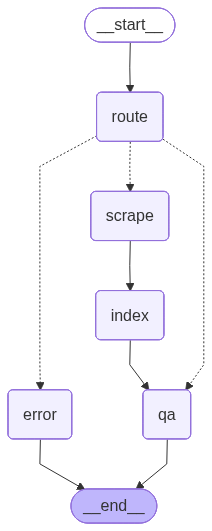

In [15]:
compiled_graph

# 10: Run Full Graph (Cold Start)

In [16]:
result = compiled_graph.invoke({
    "url": "https://example.com",
    "question": "What is this page about?",
    "page_content": None,
    "vector_store": None,
    "answer": None,
    "sources": None
})

print("📌 Answer:")
print(result["answer"])

print("\n📚 Sources:", len(result["sources"]))


🧭 Routing decision...
🕷️ Scraping page...
📦 Building FAISS index...
🤖 Answering question...
📌 Answer:
This page is about an example domain used for documentation purposes, where you can test and demonstrate website features without requiring permission.

📚 Sources: 1


# 11: Run Graph Again (Index Reuse)

In [17]:
result2 = compiled_graph.invoke({
    "url": "https://example.com",
    "question": "Is this page for testing?",
    "page_content": None,
    "vector_store": result["vector_store"],
    "answer": None,
    "sources": None
})

print("📌 Answer:")
print(result2["answer"])


🧭 Routing decision...
🤖 Answering question...
📌 Answer:
❌ Answer not found in the provided page content.
